Code to calculate the total referrals for the pre- and post-implementation periods for services using the AI-enabled tool, match the services to most similar other services not using the tool and plot Figure 2 and perform the statistical tests

In [1]:
import pandas as pd
import numpy as np
from datetime import date
import os
import math
from scipy.stats import chi2_contingency 
import datetime
from dateutil.relativedelta import relativedelta as relativedelta
from iteration_utilities import deepflatten
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import io
import sys
import scipy
from numpy.linalg import norm
import glob

from scipy.spatial.distance import cityblock


data_folder="./Monthly data/"

folder_figures_save='/Users/johanna/Library/CloudStorage/GoogleDrive-johanna@limbic.ai/Shared drives/05_Research/Publications (research papers)/Clinical/Increased_Access/Figures/'


### Combine and clean data

In [2]:
os.chdir(data_folder)
extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]

#combine all csv files
combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ]) 

#combine all excel files
extension_excel = 'xlsx'
all_filenames_excel = [i for i in glob.glob('*.{}'.format(extension_excel))]
combined_excel = pd.concat([pd.read_excel(f, na_values = '*') for f in all_filenames_excel])

# change date format                                                  
combined_excel['REPORTING_PERIOD_START'] = combined_excel['REPORTING_PERIOD_START'].apply(lambda x: x.strftime('%d/%m/%Y'))
combined_excel['REPORTING_PERIOD_END'] = combined_excel['REPORTING_PERIOD_END'].apply(lambda x: x.strftime('%d/%m/%Y'))


#combine all
data_all = pd.concat([combined_csv, combined_excel])


In [3]:
# change 'surrey iapt' to "mind matters surrey nhs" as their name was changed from March 2022
data_all.loc[data_all["ORG_NAME2"] == 'SURREY IAPT', 'ORG_NAME2'] = 'MIND MATTERS SURREY NHS'

#combine data value columns
data_all['MEASURE_VALUE_SUPPRESSED'].update(data_all.pop('MEASURE_VALUE'))

In [4]:
# Define functions

#function to calculate the total referrals and also the monthly referrals
def get_referral_sum(data_provider, dates_previous):  

    referrals=[]
    referrals_timeline=[]
    services_total = []
    services_names =[]

    for s in data_provider['ORG_NAME2'].unique(): #all services within one provider
        data_service=data_provider[data_provider['ORG_NAME2']==s]
        r=[]
        for d in dates_previous:  #dates for previous months
            data_months=data_service[data_service['REPORTING_PERIOD_START']==d]
            try: 
                arr=np.array(data_months['MEASURE_VALUE_SUPPRESSED'][data_months['MEASURE_NAME']=='Count_SelfReferrals']) #Count_SelfReferrals  Count_ReferralsReceived                
                ref_months=int(arr[0])
                referrals.append(ref_months) 
                r.append(ref_months)
            except: 
                referrals.append(np.nan) 
                r.append(np.nan) 
        referrals_timeline.append(r) #referrals per month 
        services_total.append(sum(r)) #total referrals
        services_names.append(s) #name of service

    return services_names, services_total, referrals_timeline

#calculate the total and monthly referrals for pre and post perioud
def get_referral_rates(dates_previous, dates_after, data): 
    service, referrals_total_before, timeline_referrals_before = get_referral_sum(data, dates_previous)
    service, referrals_total_after, timeline_referrals_after = get_referral_sum(data, dates_after)

    return service, referrals_total_before, referrals_total_after, timeline_referrals_before, timeline_referrals_after


#find referal numbers for each service depending on their launch date
def get_referral_service(input_data, months = 0): 
    service_ind=[]
    service=input_data['service']
    for k in data_all['ORG_NAME2']: #tag the service
        if k.lower().startswith(service.lower()):
            service_ind.append(True)
        else: 
            service_ind.append(False)
    data_all['service_index']=np.array(service_ind)
    data_provider=data_all[data_all['service_index']==True]
    dt_object = datetime.datetime.strptime(input_data['start_date'],  "%d/%m/%Y") #date when services within the provider went live 
    dt_object2 = datetime.datetime.strptime(input_data['final_date'],  "%d/%m/%Y")
    diff=dt_object2-dt_object

    pre_dt_start = datetime.datetime.strptime(input_data['pre_start'],  "%d/%m/%Y") #pre period start date
    pre_dt_final = datetime.datetime.strptime(input_data['pre_final'],  "%d/%m/%Y") #pre period end date
    pre_diff = pre_dt_final - pre_dt_start

    date_after=[dt_object + relativedelta(months=i) for i in range(months, round(diff.days/30))]
    date_pre=[pre_dt_start + relativedelta(months=i) for i in range(months, round(pre_diff.days/30))]
    
    dates_after_string=[d.strftime("%d/%m/%Y").split(' ')[0] for d in date_after]
    dates_before_string=[d.strftime("%d/%m/%Y").split(' ')[0] for d in date_pre]

    return get_referral_rates(dates_before_string, dates_after_string,data_provider)



def find_all_referrals(months):

    output =[]
    total_referrals_pre_post_tool = []
    average_referrals_pre_post_tool = []
    referral_timeline_tool_pre = []
    referral_timeline_tool_post = []
    referral_timeline_nhs_pre = []
    referral_timeline_nhs_post = []
    total_referrals_pre_post_nhs = []
    average_referrals_pre_post_nhs = []
    service_name = []
    
    for i, input_data in enumerate(inputs_services):

        output=get_referral_service(input_data,months=months) #name of service, pre total referrals, post toal referrals, pre timeline monthly referrals, post timeline monthly referrals
        service_name.append(output[0])
        total_referrals_pre_post_tool.append([output[1],output[2]])
        referral_timeline_tool_pre.append(output[3])
        referral_timeline_tool_post.append(output[4])

    results={'service': service_name,
        'total_referrals_pre_post_tool': total_referrals_pre_post_tool, 
    'referral_timeline_tool_pre': referral_timeline_tool_pre, 
    'referral_timeline_tool_post': referral_timeline_tool_post,
    }
 
    return results

In [5]:
# Define the launch dates for services and a quarter before (3-months) and quarter after (3-months)

all_services=data_all['ORG_NAME2'].unique()

input_data_insight={"service":'insight',
    'start_date':'01/01/2022',
    'final_date':'01/04/2022',   #post period Q1 2022
    'pre_start': '01/07/2021',    
    'pre_final': '01/10/2021',    #pre period Q3 2021
}


input_data_surrey={"service":'mind matters surrey nhs', #name was changed to "mind matters surrey nhs" from March 2022
    'start_date':'01/10/2021',
    'final_date':'01/01/2022',   # post period Q4 2021
    'pre_start': '01/04/2021',    
    'pre_final': '01/07/2021',    #pre period Q2 2021             
} 


input_data_trent={"service":'trent',
    'start_date':'01/10/2021',
    'final_date':'01/01/2022',   # post period Q4 2021
    'pre_start': '01/04/2021',    
    'pre_final': '01/07/2021',    #pre period Q2 2021                               
} 

input_data_vita={"service":'vita health',
    'start_date':'01/01/2021',   
    'final_date':'01/04/2021', # post period Q1 2021
    'pre_start': '01/10/2020',    
    'pre_final': '01/01/2021',    #pre period Q4 2020  
} 

inputs_services=[input_data_insight, input_data_surrey, input_data_trent, input_data_vita]

In [6]:
# find referrals to all the services using the AI-enabled self-referral tool
results = find_all_referrals(0)

## Define matches for services
Use the same matched services as in the total-referral analysis.

In [7]:
input_data_nhs_1={"service":'SELF HELP SERVICES (STOCKPORT)',
    'start_date':'01/01/2022',
    'final_date':'01/04/2022',   #post period Q1 2022
    'pre_start': '01/07/2021',    
    'pre_final': '01/10/2021',    #pre period Q3 2021
} 

input_data_nhs_2={"service":'MERTON IAPT',
    'start_date':'01/01/2022',
    'final_date':'01/04/2022',   #post period Q1 2022
    'pre_start': '01/07/2021',    
    'pre_final': '01/10/2021',    #pre period Q3 2021
} 

input_data_nhs_3={"service":'FAVERSHAM COUNSELLING SERVICE LTD',
    'start_date':'01/01/2022',
    'final_date':'01/04/2022',   #post period Q1 2022
    'pre_start': '01/07/2021',    
    'pre_final': '01/10/2021',    #pre period Q3 2021
} 

input_data_nhs_4={"service":'WE ARE WITH YOU IN SURREY',
    'start_date':'01/01/2022',
    'final_date':'01/04/2022',   #post period Q1 2022
    'pre_start': '01/07/2021',    
    'pre_final': '01/10/2021',    #pre period Q3 2021
} 

input_data_nhs_5={"service":'BLACKPOOL TEACHING HOSPITALS NHS FOUNDATION TRUST',
    'start_date':'01/01/2022',
    'final_date':'01/04/2022',   #post period Q1 2022
    'pre_start': '01/07/2021',    
    'pre_final': '01/10/2021',    #pre period Q3 2021
} 

input_data_nhs_6={"service":'UNIVERSITY MEDICAL CENTRE',
    'start_date':'01/01/2022',
    'final_date':'01/04/2022',   #post period Q1 2022
    'pre_start': '01/07/2021',    
    'pre_final': '01/10/2021',    #pre period Q3 2021
} 

input_data_nhs_7={"service":'BROMLEY HEALTHCARE',
    'start_date':'01/01/2022',
    'final_date':'01/04/2022',   #post period Q1 2022
    'pre_start': '01/07/2021',    
    'pre_final': '01/10/2021',    #pre period Q3 2021
} 

#match for surrey
input_data_nhs_8={"service":'JOHNSON STREET',
    'start_date':'01/10/2021',
    'final_date':'01/01/2022',   # post period Q4 2021
    'pre_start': '01/04/2021',    
    'pre_final': '01/07/2021',    #pre period Q2 2021   
} # 

#match for trent
input_data_nhs_9 ={"service":'WAVERLEY ROAD',
    'start_date':'01/10/2021',
    'final_date':'01/01/2022',   # post period Q4 2021
    'pre_start': '01/04/2021',    
    'pre_final': '01/07/2021',    #pre period Q2 2021 
} 

#matches for vita
input_data_nhs_10 ={"service":'OXLEAS NHS FOUNDATION TRUST',
    'start_date':'01/01/2021',   
    'final_date':'01/04/2021', # post period Q1 2021
    'pre_start': '01/10/2020',    
    'pre_final': '01/01/2021',    #pre period Q4 2020  
} 

input_data_nhs_11 ={"service":'DEVON PARTNERSHIP NHS TRUST',
    'start_date':'01/01/2021',   
    'final_date':'01/04/2021', # post period Q1 2021
    'pre_start': '01/10/2020',    
    'pre_final': '01/01/2021',    #pre period Q4 2020  
}  
   
input_data_nhs_12 ={"service":'CENTRE FOR PSYCHOLOGY',
    'start_date':'01/01/2021',   
    'final_date':'01/04/2021', # post period Q1 2021
    'pre_start': '01/10/2020',    
    'pre_final': '01/01/2021',    #pre period Q4 2020  
}  

input_data_nhs_13={"service":'DOVER COUNSELLING CENTRE HQ',
    'start_date':'01/01/2021',   
    'final_date':'01/04/2021', # post period Q1 2021
    'pre_start': '01/10/2020',    
    'pre_final': '01/01/2021',    #pre period Q4 2020  
} 

input_data_nhs_14={"service":'WARRINGTON PSYCHOLOGICAL SERVICE',
    'start_date':'01/01/2021',   
    'final_date':'01/04/2021', # post period Q1 2021
    'pre_start': '01/10/2020',    
    'pre_final': '01/01/2021',    #pre period Q4 2020  
}  


inputs_services_separate_nhs = [input_data_nhs_1, input_data_nhs_2, input_data_nhs_3, input_data_nhs_4,
                               input_data_nhs_5, input_data_nhs_6, input_data_nhs_7, input_data_nhs_8, 
                               input_data_nhs_9, input_data_nhs_10, input_data_nhs_11, input_data_nhs_12,
                               input_data_nhs_13, input_data_nhs_14]


In [8]:
output =[]
referral_timeline_nhs_pre = []
referral_timeline_nhs_post = []
total_referrals_pre_post_nhs = []
average_referrals_pre_post_nhs = []
service_name = []

for i, input_data in enumerate(inputs_services_separate_nhs):

    output=get_referral_service(input_data,months=0) #name of service, pre total referrals, post toal referrals, pre timeline monthly referrals, post timeline monthly referrals
    service_name.append(output[0])
    total_referrals_pre_post_nhs.append([output[1],output[2]])
    referral_timeline_nhs_pre.append(output[3])
    referral_timeline_nhs_post.append(output[4])


results_nhs ={'service': service_name,
    'total_referrals_pre_post_nhs': total_referrals_pre_post_nhs, 
'referral_timeline_nhs_pre': referral_timeline_nhs_pre, 
'referral_timeline_nhs_post': referral_timeline_nhs_post,
}

In [9]:
post_tool = np.nansum(results['total_referrals_pre_post_tool'][0][1] + results['total_referrals_pre_post_tool'][1][1] +
          results['total_referrals_pre_post_tool'][2][1] + results['total_referrals_pre_post_tool'][3][1]) 

pre_tool = np.nansum(results['total_referrals_pre_post_tool'][0][0] + results['total_referrals_pre_post_tool'][1][0] +
          results['total_referrals_pre_post_tool'][2][0] + results['total_referrals_pre_post_tool'][3][0])

pre_post_nhs = np.nansum(results_nhs['total_referrals_pre_post_nhs'],axis = 0)


pre_nhs = pre_post_nhs[0][0]
post_nhs = pre_post_nhs[1][0]

In [10]:
# add the aeroport font for the plots

import matplotlib.font_manager as fm

font_path = '/Users/johanna/Downloads/Aeroport.ttf'  # the location of the font file
my_font = fm.FontProperties(fname=font_path)  # get the font based on the font_path

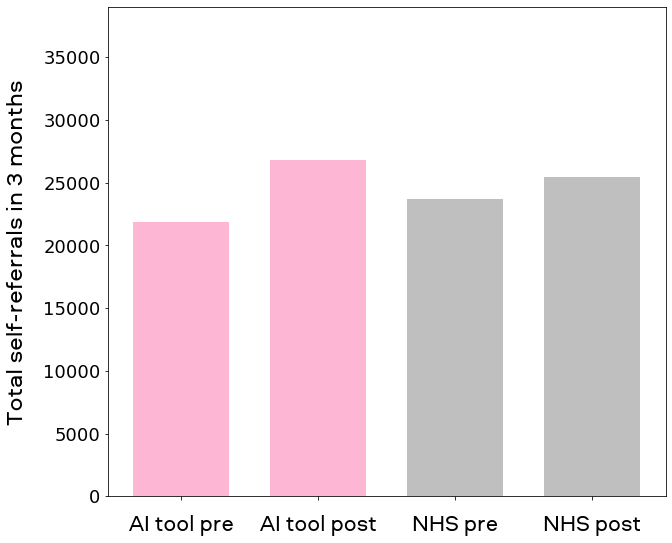

In [11]:
fig, ax = plt.subplots(figsize=(10, 9))

plt.bar([0,1], [pre_tool, post_tool], color = '#fdb6d3', width=0.7)
plt.bar([2,3], [pre_nhs, post_nhs], color = '#bfbfbf',  width=0.7)


plt.xticks([0,1,2,3], ['AI tool pre', 'AI tool post', 'NHS pre', 'NHS post'], fontsize=22, font = my_font)

plt.ylabel('Total self-referrals in 3 months', fontsize=24, font = my_font, labelpad=15)

ax.tick_params(axis='x', which='major', pad=15)

plt.yticks(fontsize=18)

plt.ylim(0,39000)


image_format = 'png' # e.g .png, .svg, etc.
image_name = folder_figures_save+'total_self__referrals.png'

fig.savefig(image_name, format=image_format, bbox_inches="tight",dpi=1200)


In [12]:
chi2_contingency([[pre_tool, post_tool],[pre_nhs,post_nhs]])

(106.5287728484236,
 5.646667679210544e-25,
 1,
 array([[22660.72972559, 25984.27027441],
        [22919.27027441, 26280.72972559]]))

In [13]:
print( 'percentage change for the self-referral tool', round(((post_tool - pre_tool)/post_tool)*100,2) )
print('percentage change for nhs', round(((post_nhs-pre_nhs)/post_nhs)*100,2) )

percentage change for the self-referral tool 18.42
percentage change for nhs 6.87
